In [1]:
import zarr
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
from rich import print
from pathlib import Path
from omegaconf import OmegaConf
from dataclasses import dataclass
from alive_progress import alive_it
from sortedcontainers import SortedList
from scipy import stats
from walrus_workshop.utils import get_key_value_from_string
from walrus_workshop.walrus import get_trajectory
from walrus_workshop.model import load_sae
from walrus_workshop import metrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using device: cuda


In [2]:
# Load the config
cfg = OmegaConf.load("configs/train.yaml")

# Load the trained SAE
checkpoint_path = (
    Path("checkpoints")
    / "sae_checkpoint_blocks.20.space_mixing.activation_source_test_k_active=32_k_aux=2048_latent=22528_beta=0.1.pt"
)
sae_model, sae_config = load_sae(checkpoint_path)
sae_model = sae_model.to(device).eval()

In [3]:
trajectory_id = 50 # 50
trajectory, trajectory_metadata = get_trajectory(cfg.walrus.dataset, trajectory_id)

# Load file list of the activations
activations_dir = (
    Path("activations")
    / "test"
    / "blocks.20.space_mixing.activation"
    / cfg.walrus.dataset
)
act_files = sorted(glob.glob(str(activations_dir / f"*_traj_{trajectory_id}_*")))
# List of steps with activations (starting step)
steps = np.array([int(get_key_value_from_string(file_name, "step")) for file_name in act_files])

step_index = 3
step = steps[step_index]
simulation_chunk = trajectory['input_fields'][0, step:step+cfg.walrus.n_steps_input, :, :, 0, :]


In [4]:
def calculate_metrics(Pi_omega, T_omega, k_centers, k_forcing=None):
    dk = k_centers[1] - k_centers[0]
    metrics = {}
    
    # 1. Maximum flux magnitude and location
    metrics['Pi_max'] = np.max(Pi_omega)
    metrics['Pi_min'] = np.min(Pi_omega)
    metrics['k_at_Pi_max'] = k_centers[np.argmax(Pi_omega)]
    
    # 2. Mean flux in inertial range (if k_forcing provided)
    if k_forcing is not None:
        inertial_mask = k_centers > k_forcing
        metrics['Pi_mean_inertial'] = np.mean(Pi_omega[inertial_mask])
    else:
        # Use middle third of wavenumber range as proxy
        n = len(k_centers)
        mid_mask = (np.arange(n) > n//3) & (np.arange(n) < 2*n//3)
        metrics['Pi_mean_middle'] = np.mean(Pi_omega[mid_mask])
    
    # 3. Net enstrophy transfer (should be ~0 for conservative nonlinearity)
    metrics['net_transfer'] = np.sum(T_omega) * dk
    
    # 4. Forward vs inverse fraction
    forward_flux = np.sum(np.maximum(Pi_omega, 0))
    inverse_flux = np.sum(np.maximum(-Pi_omega, 0))
    total = forward_flux + inverse_flux
    if total > 0:
        metrics['forward_fraction'] = forward_flux / total
        metrics['inverse_fraction'] = inverse_flux / total
    else:
        metrics['forward_fraction'] = 0.5
        metrics['inverse_fraction'] = 0.5
    
    # 5. Cascade directionality index: ranges from -1 (inverse) to +1 (forward)
    metrics['directionality'] = (forward_flux - inverse_flux) / (total + 1e-16)
    
    # 6. Flux-weighted mean wavenumber (where is transfer happening?)
    weights = np.abs(Pi_omega)
    if np.sum(weights) > 0:
        metrics['k_flux_weighted'] = np.sum(k_centers * weights) / np.sum(weights)
    else:
        metrics['k_flux_weighted'] = 0
    
    # 7. Transfer spectrum moments
    T_abs = np.abs(T_omega)
    if np.sum(T_abs) > 0:
        metrics['k_transfer_centroid'] = np.sum(k_centers * T_abs) / np.sum(T_abs)
        metrics['transfer_bandwidth'] = np.sqrt(
            np.sum((k_centers - metrics['k_transfer_centroid'])**2 * T_abs) / np.sum(T_abs)
        )
    
    # 8. Plateau flux estimate (median of positive flux region)
    positive_flux = Pi_omega[Pi_omega > 0]
    if len(positive_flux) > 0:
        metrics['Pi_plateau'] = np.median(positive_flux)
    else:
        metrics['Pi_plateau'] = 0
    
    # 9. Enstrophy dissipation estimate (flux at high k)
    high_k_mask = k_centers > 0.7 * k_centers.max()
    metrics['Pi_high_k'] = np.mean(Pi_omega[high_k_mask])
    return metrics

In [6]:
@dataclass
class EnstrophyFluxFeatures:
    k: np.array
    Pi: np.array
    T: np.array


directionality = np.array([])
forward_fraction = np.array([])
pi_plateau = np.array([])
features = np.array([])
deformation = np.array([])
t = np.array([])
for step_index in alive_it(range(len(steps)), force_tty=True):
    step = steps[step_index]
    simulation_chunk = trajectory['input_fields'][0, step:step+cfg.walrus.n_steps_input, :, :, 0, :]

    act = zarr.open(act_files[step_index], mode="r")
    act = torch.from_numpy(np.array(act)).to(device)
    with torch.no_grad():
        _, code, _ = sae_model(act)
    code = code.cpu().numpy().reshape(6, 32, 32, -1)

    for i in range(cfg.walrus.n_steps_input):
        if step+i in t:
            continue
        enstrophy_flux = EnstrophyFluxFeatures(*metrics.compute_enstrophy_flux(simulation_chunk[i, ..., 2], simulation_chunk[i, ..., 3]))
        total_deformation = metrics.compute_deformation(simulation_chunk[i, ..., 2], simulation_chunk[i, ..., 3])[0].mean()
        m = calculate_metrics(enstrophy_flux.Pi, enstrophy_flux.T, enstrophy_flux.k)
        directionality = np.concatenate([directionality, [m['directionality']]])
        forward_fraction = np.concatenate([forward_fraction, [m['forward_fraction']]])
        pi_plateau = np.concatenate([pi_plateau, [m['Pi_plateau']]])
        features = np.concatenate([features, code.mean(axis=(1, 2))[i].ravel()])
        deformation = np.concatenate([deformation, [total_deformation]])
        t = np.concatenate([t, [step+i]])
features = features.reshape(len(t), -1)

|                                        | ▁▃▅ 0/34 [0%] in 0s (~0s, 0.0/s) 

|████████████████████████████████████████| 34/34 [100%] in 24.6s (1.37/s)       


In [7]:
@dataclass
class Feature:
    index: int
    corr: float
    pval: float

    def __lt__(self, other):
        return self.corr < other.corr

feature_list = SortedList()
null_feature_list = SortedList()
num_null_samples = 10
# feature_list_dEdt = SortedList()
for feature_idx in alive_it(range(features.shape[1]), force_tty=True):
    target = deformation.copy()
    s,p = stats.spearmanr(features[:, feature_idx], target)
    if np.isfinite(s):
        feature_list.add(Feature(feature_idx, s, p))
    s_max = -np.inf
    p_max = 0
    for i in range(num_null_samples):
        np.random.shuffle(target)
        s,p = stats.spearmanr(features[:, feature_idx], target)
        if np.isfinite(s):
            if s > s_max:
                s_max = s
                p_max = p
            
    null_feature_list.add(Feature(feature_idx, s_max, 0))

on 0: /tmp/ipykernel_111287/988947434.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
        s,p = stats.spearmanr(features[:, feature_idx], target)
      /tmp/ipykernel_111287/988947434.py:22: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
        s,p = stats.spearmanr(features[:, feature_idx], target)


|████████████████████████████████████████| 22528/22528 [100%] in 24.7s (911.57/s


In [8]:
corr = np.array([feature.corr for feature in feature_list])
null_corr = np.array([feature.corr for feature in null_feature_list])
print(f"Largest correlations: {feature_list[-1].corr}, (p={feature_list[-1].pval}) (index={feature_list[-1].index})")
print(f"Null correlation: {null_feature_list[-1].corr}, (p={null_feature_list[-1].pval})")
print(f"Number of features with correlation > null_E_corr: {np.sum(corr > null_corr.max())} / {len(corr)} ({np.sum(corr > null_corr.max()) / len(corr) * 100:.2f}%)")

Largest correlations: 0.4761090204384032, (p=2.8453466090068183e-07) (index=4921)

Null correlation: 0.3570859651589214, (p=0)

Number of features with correlation > null_E_corr: 26 / 6664 (0.39%)

trajectory_id: 50

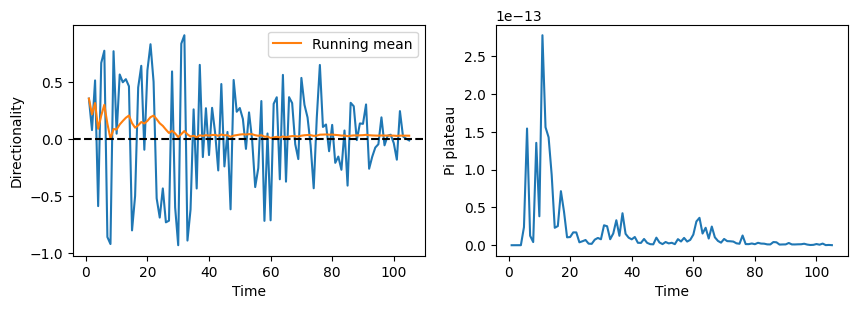

In [9]:
sort_me = np.unique(t, return_index=True)[1]
print(f"trajectory_id: {trajectory_id}")
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
ax = axs[0]
ax.plot(t[sort_me], directionality[sort_me])
ax.plot(t[sort_me], np.cumsum(directionality[sort_me]) / np.arange(1, len(t[sort_me])+1), label='Running mean')
ax.axhline(0, color='k', linestyle='--')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Directionality')
ax = axs[1]
ax.plot(t[sort_me], pi_plateau[sort_me])
ax.set_xlabel('Time')
ax.set_ylabel('Pi plateau')
plt.show()


Text(0, 0.5, 'Enstrophy Transfer')

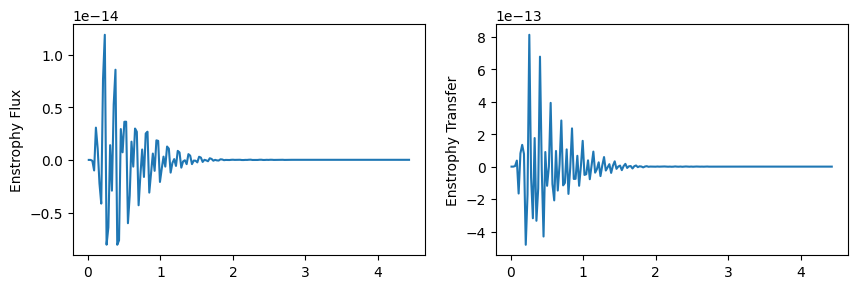

In [24]:
@dataclass
class EnstrophyFluxFeatures:
    k: np.array
    Pi: np.array
    T: np.array

step_index = 3
step = steps[step_index]
simulation_chunk = trajectory['input_fields'][0, step:step+cfg.walrus.n_steps_input, :, :, 0, :]

enstrophy_flux = EnstrophyFluxFeatures(*metrics.compute_enstrophy_flux(simulation_chunk[0, ..., 2], simulation_chunk[0, ..., 3]))
m = calculate_metrics(enstrophy_flux.Pi, enstrophy_flux.T, enstrophy_flux.k)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
ax = axs[0]
ax.plot(enstrophy_flux.k, enstrophy_flux.Pi)
# ax.axhline(m['directionality'], color='k', linestyle='--')
ax.set_ylabel('Enstrophy Flux')
ax = axs[1]
ax.plot(enstrophy_flux.k, enstrophy_flux.T)
ax.set_ylabel('Enstrophy Transfer')


In [25]:
# fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# axs[0].imshow(simulation_chunk[0, ..., 2], cmap='gray')
# axs[0].set_title('velocity - x')
# axs[1].imshow(simulation_chunk[0, ..., 3], cmap='gray')
# axs[1].set_title('velocity - y')
# plt.show()